In [2]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [23]:
import PIL
from PIL import Image
PIL.__version__

'8.2.0'

In [15]:
import tempfile

In [26]:
import numpy as np
imarray = np.random.rand(100,100,3) * 255
im = Image.fromarray(imarray.astype('uint8'))

In [56]:
with tempfile.NamedTemporaryFile('w+b',suffix='.jpg') as f:
    im.save(f,'JPEG')
    f.seek(0)
    x = Image.open(f)

In [60]:
np.array(x).shape

()

In [21]:
temp.name

'C:\\Users\\tornikeo\\AppData\\Local\\Temp\\tmp6wyjw2vm.jpg'

In [7]:
import torchvision

In [9]:
from model.Eval import Decoder, Encoder, Transform, Stylizer
from model.Eval import get_decoder, get_encoder, get_transformer

In [11]:
from model.Eval import Stylizer

In [14]:
import matplotlib

matplotlib.__version__

'3.4.2'

In [12]:
net = Stylizer()

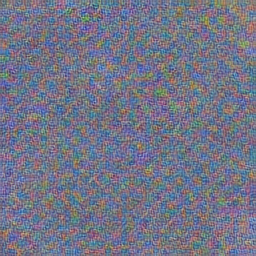

In [19]:
content = Image.fromarray(
    torch.randint(0,255, size=(256,256,3), dtype=torch.uint8).numpy(),
)

style = Image.fromarray(
    torch.randint(0,255, size=(256,256,3), dtype=torch.uint8).numpy(),
)
net(content=content, style=style)

In [22]:
torchvision.__version__

'0.11.2+cu113'

In [10]:
import os
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image


class Stylizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.transform = get_transformer()
        self.decoder = get_decoder()
        self.encoder = get_encoder()
        
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        self.decoder.load_state_dict(torch.load('model_and_weights/decoder_iter_500000.pth'))
        self.encoder.load_state_dict(torch.load('model_and_weights/vgg_normalised.pth'))
        self.transform.load_state_dict(torch.load('model_and_weights/transformer_iter_500000.pth'))

        self.norm = nn.Sequential(*list(self.encoder.children())[:1])
        self.enc_1 = nn.Sequential(*list(self.encoder.children())[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*list(self.encoder.children())[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*list(self.encoder.children())[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*list(self.encoder.children())[18:31])  # relu3_1 -> relu4_1
        self.enc_5 = nn.Sequential(*list(self.encoder.children())[31:44])  # relu4_1 -> relu5_1

        self.norm.to(self.device)
        self.enc_1.to(self.device)
        self.enc_2.to(self.device)
        self.enc_3.to(self.device)
        self.enc_4.to(self.device)
        self.enc_5.to(self.device)
        self.transform.to(self.device)
        self.decoder.to(self.device)
    
    @torch.no_grad()
    def forward(self, style_path, content_path, iters = 1):
        style = transforms.ToTensor()(Image.open(style_path))
        content = transforms.ToTensor()(Image.open(content_path))

        style = style.to(self.device).unsqueeze(0)
        content = content.to(self.device).unsqueeze(0)

        c4_1 = content.detach().clone()
        s4_1 = style.detach().clone()

        for i in range(iters):
            for enc in [self.enc_1,self.enc_2,self.enc_3,self.enc_4]:
                c4_1 = enc(c4_1)
            c5_1 = self.enc_5(c4_1)

            for enc in [self.enc_1,self.enc_2,self.enc_3,self.enc_4]:
                s4_1 = enc(s4_1)
            s5_1 = self.enc_5(s4_1)

            c_stylized = self.decoder(self.transform(c4_1, s4_1, c5_1, s5_1))

            c4_1 = c_stylized.detach().clone()
            s4_1 = style.detach().clone()

        result = c_stylized.detach().clone().cpu()[0].permute(1,2,0).clamp(0,1).numpy()
        os.makedirs('generated',exist_ok=True)
        plt.imsave('generated/result.jpg',(result * 255).astype('uint8'))
        return 'generated/result.jpg'
    
stn = Stylizer()
res = stn('uploads/starry.jpg','uploads/chicago.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'model_and_weights/decoder_iter_500000.pth'

In [3]:
transform = Transform(in_planes=512)

In [4]:
decoder = Decoder()
encoder = Encoder()

In [5]:
decoder_weights = torch.load('decoder_iter_500000.pth')
encoder_weights = torch.load('vgg_normalised.pth')
transformer_weights = torch.load('transformer_iter_500000.pth')

In [6]:
decoder.decoder.load_state_dict(decoder_weights)
encoder.encoder.load_state_dict(encoder_weights)
transform.load_state_dict(transformer_weights)

<All keys matched successfully>

In [7]:
import torch.nn as nn
norm = nn.Sequential(*list(encoder.encoder.children())[:1])
enc_1 = nn.Sequential(*list(encoder.encoder.children())[:4])  # input -> relu1_1
enc_2 = nn.Sequential(*list(encoder.encoder.children())[4:11])  # relu1_1 -> relu2_1
enc_3 = nn.Sequential(*list(encoder.encoder.children())[11:18])  # relu2_1 -> relu3_1
enc_4 = nn.Sequential(*list(encoder.encoder.children())[18:31])  # relu3_1 -> relu4_1
enc_5 = nn.Sequential(*list(encoder.encoder.children())[31:44])  # relu4_1 -> relu5_1

In [8]:
device = torch.device('cuda')

In [9]:
norm.to(device)
enc_1.to(device)
enc_2.to(device)
enc_3.to(device)
enc_4.to(device)
enc_5.to(device)
transform.to(device)
decoder.to(device)

Decoder(
  (decoder): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): ReflectionPad2d((1, 1, 1, 1))
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): ReflectionPad2d((1, 1, 1, 1))
    (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): Upsample(scale_factor=2.0, mode=nearest)
    (17): ReflectionPad2d((1, 1, 1, 1))
    (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (19): ReLU()
    (20): ReflectionPad2d((1, 1, 1, 1))
    (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (22): ReLU()
    (23): Upsample(scale_factor=2.0, mode=

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image
import torch.utils.data as data
import itertools

# class CSPairs(data.Dataset):
#     def __init__(self, content_dir, style_dir):
#         super().__init__()
        
#         self.contents = tuple(itertools.cycle(os.listdir(content_dir)))
#         self.styles = tuple(os.listdir(style_dir))
#         self.paths = tuple(zip())
#     def __len__(self):
#         return len(self.content)
#     def __getitem(self, idx):
#         content = read_image(self.contents[idx])
#         style = read_image(self.styles[idx])
#         return content, style
    
# csdata = data.DataLoader(CSPairs('input/','style/'))

# next(iter(csdata))
# for c,s in csdata:
#     print(c.shape,s.shape)
import torchvision.transforms as transforms


In [11]:
style.shape, content.shape

(torch.Size([1, 3, 405, 512]), torch.Size([1, 3, 512, 512]))

In [21]:
from pathlib import Path


'wreck'

In [27]:
from glob import glob
css = {}

for style_path in glob('style/*.jpg'):
    for content_path in glob('input/*.jpg'):
        print(style_path, content_path)
        
        cs_name = Path(content_path).with_suffix('').name + '-' + Path(style_path).with_suffix('').name
        print(cs_name)
        
        style = transforms.ToTensor()(Image.open(style_path))
        content = transforms.ToTensor()(Image.open(content_path))

        style = style.to(device).unsqueeze(0)
        content = content.to(device).unsqueeze(0)
        for i in range(2):
            with torch.no_grad():
                c4_1 = content.detach().clone()
                for enc in [enc_1,enc_2,enc_3,enc_4]:
                    c4_1 = enc(c4_1)
                c5_1 = enc_5(c4_1)

                s4_1 = style.detach().clone()
                for enc in [enc_1,enc_2,enc_3,enc_4]:
                    s4_1 = enc(s4_1)
                s5_1 = enc_5(s4_1)

                cs = decoder(transform(c4_1, s4_1, c5_1, s5_1))
                cs.clamp(0,255)
        css[cs_name] = cs.cpu().detach()

style\1.jpg input\chicago.jpg
chicago-1
style\1.jpg input\Content.jpg
Content-1
style\1.jpg input\rocky-beach.jpg
rocky-beach-1
style\1.jpg input\snowy-beach.jpg
snowy-beach-1
style\1.jpg input\snowy-forest.jpg
snowy-forest-1
style\1.jpg input\snowy-town.jpg
snowy-town-1
style\candy.jpg input\chicago.jpg
chicago-candy
style\candy.jpg input\Content.jpg
Content-candy
style\candy.jpg input\rocky-beach.jpg
rocky-beach-candy
style\candy.jpg input\snowy-beach.jpg
snowy-beach-candy
style\candy.jpg input\snowy-forest.jpg
snowy-forest-candy
style\candy.jpg input\snowy-town.jpg
snowy-town-candy
style\Composition-VII.jpg input\chicago.jpg
chicago-Composition-VII
style\Composition-VII.jpg input\Content.jpg
Content-Composition-VII
style\Composition-VII.jpg input\rocky-beach.jpg
rocky-beach-Composition-VII
style\Composition-VII.jpg input\snowy-beach.jpg
snowy-beach-Composition-VII
style\Composition-VII.jpg input\snowy-forest.jpg
snowy-forest-Composition-VII
style\Composition-VII.jpg input\snowy-town

In [38]:
css = {k:v.permute(0,2,3,1) for k,v in css.items()}

In [13]:
content = content.cpu()

In [47]:
for k,v in css.items():
    plt.imsave('output/'+k+'.jpg',(v[0]).clamp(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


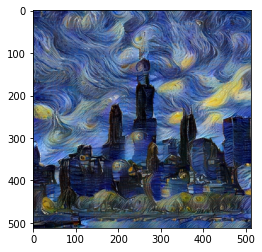

In [14]:
import torchvision
plt.imshow(torchvision.utils.make_grid(content).permute(1,2,0))